In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn 
import pandas as pd 
import os 
import sys
import time 
import tensorflow as tf 
from tensorflow import keras 

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# 导入数据
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state= 11)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)
print(x_valid_scaled.shape)
print(x_test_scaled.shape)
print(np.max(x_train), np.min(x_train), np.max(x_train_scaled), np.min(x_train_scaled))

(11610, 8)
(3870, 8)
(5160, 8)
28566.0 -124.3 81.80221745207753 -2.3594398206242224


In [7]:
# RandomizedSearchCV
# 1. 转化为sklearn 的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1, 
                layer_size = 30,
                learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, 
                                    activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train, epochs = 100,
                 validation_data=(x_valid_scaled, y_valid), 
                 callbacks = callbacks)


Epoch 1/100
363/363 [==============================] - 0s 1ms/step - loss: 1.3039 - val_loss: 0.7682
Epoch 2/100
363/363 [==============================] - 0s 799us/step - loss: 0.6979 - val_loss: 0.6765
Epoch 3/100
363/363 [==============================] - 0s 794us/step - loss: 0.6058 - val_loss: 0.6186
Epoch 4/100
363/363 [==============================] - 0s 803us/step - loss: 0.5585 - val_loss: 0.5766
Epoch 5/100
363/363 [==============================] - 0s 787us/step - loss: 0.5304 - val_loss: 0.5453
Epoch 6/100
363/363 [==============================] - 0s 791us/step - loss: 0.4999 - val_loss: 0.5244
Epoch 7/100
363/363 [==============================] - 0s 809us/step - loss: 0.4892 - val_loss: 0.5086
Epoch 8/100
363/363 [==============================] - 0s 800us/step - loss: 0.4791 - val_loss: 0.4937
Epoch 9/100
363/363 [==============================] - 0s 819us/step - loss: 0.4581 - val_loss: 0.4843
Epoch 10/100
363/363 [==============================] - 0s 803us/step - los

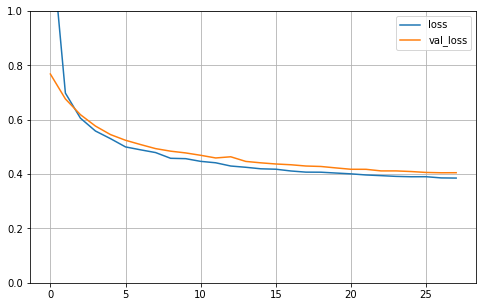

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [ ]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)), a<= x <= b

param_distribution = {
    "hidden_layers":[1,2,3,4],
    "layer_size": [20, 30, 40, 50, 70, 90, 100],
    "learning_rate": reciprocal(1e-4, 1e-2)
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                                     param_distribution,
                                     n_iter = 10, 
                                     n_jobs = 1)

random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks=callbacks)

# cross_validation: 交叉验证


Epoch 1/100
291/291 [==============================] - 0s 1ms/step - loss: 4.1682 - val_loss: 3.2962
Epoch 2/100
291/291 [==============================] - 0s 948us/step - loss: 2.5382 - val_loss: 2.1030
Epoch 3/100
291/291 [==============================] - 0s 919us/step - loss: 1.7377 - val_loss: 1.5699
Epoch 4/100
291/291 [==============================] - 0s 940us/step - loss: 1.3801 - val_loss: 1.3004
Epoch 5/100
291/291 [==============================] - 0s 948us/step - loss: 1.1692 - val_loss: 1.1270
Epoch 6/100
291/291 [==============================] - 0s 918us/step - loss: 1.0247 - val_loss: 1.0028
Epoch 7/100
291/291 [==============================] - 0s 941us/step - loss: 0.9185 - val_loss: 0.9159
Epoch 8/100
291/291 [==============================] - 0s 916us/step - loss: 0.8417 - val_loss: 0.8532
Epoch 9/100
291/291 [==============================] - 0s 921us/step - loss: 0.7853 - val_loss: 0.8077
Epoch 10/100
291/291 [==============================] - 0s 931us/step - los

291/291 [==============================] - 0s 930us/step - loss: 0.8448 - val_loss: 0.8463
Epoch 9/100
291/291 [==============================] - 0s 944us/step - loss: 0.8030 - val_loss: 0.8129
Epoch 10/100
291/291 [==============================] - 0s 962us/step - loss: 0.7702 - val_loss: 0.7873
Epoch 11/100
291/291 [==============================] - 0s 957us/step - loss: 0.7447 - val_loss: 0.7668
Epoch 12/100
291/291 [==============================] - 0s 910us/step - loss: 0.7240 - val_loss: 0.7500
Epoch 13/100
291/291 [==============================] - 0s 923us/step - loss: 0.7071 - val_loss: 0.7362
Epoch 14/100
291/291 [==============================] - 0s 934us/step - loss: 0.6931 - val_loss: 0.7243
Epoch 15/100
291/291 [==============================] - 0s 937us/step - loss: 0.6813 - val_loss: 0.7141
Epoch 16/100
291/291 [==============================] - 0s 917us/step - loss: 0.6711 - val_loss: 0.7049
Epoch 17/100
291/291 [==============================] - 0s 929us/step - loss: 

291/291 [==============================] - 0s 936us/step - loss: 0.6732 - val_loss: 0.6993
Epoch 12/100
291/291 [==============================] - 0s 929us/step - loss: 0.6515 - val_loss: 0.6827
Epoch 13/100
291/291 [==============================] - 0s 962us/step - loss: 0.6355 - val_loss: 0.6710
Epoch 14/100
291/291 [==============================] - 0s 952us/step - loss: 0.6234 - val_loss: 0.6615
Epoch 15/100
291/291 [==============================] - 0s 972us/step - loss: 0.6138 - val_loss: 0.6542
Epoch 16/100
291/291 [==============================] - 0s 927us/step - loss: 0.6059 - val_loss: 0.6476
Epoch 17/100
291/291 [==============================] - 0s 950us/step - loss: 0.5990 - val_loss: 0.6416
Epoch 18/100
291/291 [==============================] - 0s 936us/step - loss: 0.5929 - val_loss: 0.6362
Epoch 19/100
291/291 [==============================] - 0s 915us/step - loss: 0.5871 - val_loss: 0.6310
Epoch 20/100
291/291 [==============================] - 0s 938us/step - loss:

291/291 [==============================] - 0s 933us/step - loss: 0.5877 - val_loss: 0.6360
Epoch 26/100
291/291 [==============================] - 0s 935us/step - loss: 0.5816 - val_loss: 0.6297
Epoch 27/100
291/291 [==============================] - 0s 943us/step - loss: 0.5759 - val_loss: 0.6233
Epoch 28/100
291/291 [==============================] - 0s 910us/step - loss: 0.5703 - val_loss: 0.6175
Epoch 29/100
291/291 [==============================] - 0s 944us/step - loss: 0.5651 - val_loss: 0.6118
Epoch 30/100
291/291 [==============================] - 0s 946us/step - loss: 0.5601 - val_loss: 0.6064
Epoch 31/100
291/291 [==============================] - 0s 932us/step - loss: 0.5552 - val_loss: 0.6011
Epoch 32/100
291/291 [==============================] - 0s 980us/step - loss: 0.5505 - val_loss: 0.5962
Epoch 33/100
291/291 [==============================] - 0s 937us/step - loss: 0.5461 - val_loss: 0.5914
Epoch 34/100
291/291 [==============================] - 0s 927us/step - loss:

291/291 [==============================] - 0s 944us/step - loss: 0.5539 - val_loss: 0.6026
Epoch 35/100
291/291 [==============================] - 0s 925us/step - loss: 0.5480 - val_loss: 0.5962
Epoch 36/100
291/291 [==============================] - 0s 933us/step - loss: 0.5424 - val_loss: 0.5899
Epoch 37/100
291/291 [==============================] - 0s 931us/step - loss: 0.5369 - val_loss: 0.5840
Epoch 38/100
291/291 [==============================] - 0s 969us/step - loss: 0.5314 - val_loss: 0.5778
Epoch 39/100
291/291 [==============================] - 0s 909us/step - loss: 0.5263 - val_loss: 0.5720
Epoch 40/100
291/291 [==============================] - 0s 929us/step - loss: 0.5211 - val_loss: 0.5661
Epoch 41/100
291/291 [==============================] - 0s 940us/step - loss: 0.5160 - val_loss: 0.5604
Epoch 42/100
291/291 [==============================] - 0s 929us/step - loss: 0.5112 - val_loss: 0.5549
Epoch 43/100
291/291 [==============================] - 0s 946us/step - loss:

291/291 [==============================] - 0s 916us/step - loss: 0.5116 - val_loss: 0.5340
Epoch 36/100
291/291 [==============================] - 0s 903us/step - loss: 0.5084 - val_loss: 0.5307
Epoch 37/100
291/291 [==============================] - 0s 907us/step - loss: 0.5056 - val_loss: 0.5270
Epoch 38/100
291/291 [==============================] - 0s 896us/step - loss: 0.5024 - val_loss: 0.5235
Epoch 39/100
291/291 [==============================] - 0s 922us/step - loss: 0.4999 - val_loss: 0.5201
Epoch 40/100
291/291 [==============================] - 0s 898us/step - loss: 0.4971 - val_loss: 0.5168
Epoch 41/100
291/291 [==============================] - 0s 894us/step - loss: 0.4944 - val_loss: 0.5139
Epoch 42/100
291/291 [==============================] - 0s 900us/step - loss: 0.4917 - val_loss: 0.5114
Epoch 43/100
291/291 [==============================] - 0s 897us/step - loss: 0.4888 - val_loss: 0.5096
Epoch 44/100
291/291 [==============================] - 0s 906us/step - loss:

291/291 [==============================] - 0s 907us/step - loss: 0.5859 - val_loss: 0.6209
Epoch 44/100
291/291 [==============================] - 0s 910us/step - loss: 0.5822 - val_loss: 0.6164
Epoch 45/100
291/291 [==============================] - 0s 912us/step - loss: 0.5785 - val_loss: 0.6108
Epoch 46/100
291/291 [==============================] - 0s 893us/step - loss: 0.5746 - val_loss: 0.6083
Epoch 47/100
291/291 [==============================] - 0s 916us/step - loss: 0.5708 - val_loss: 0.6026
Epoch 48/100
291/291 [==============================] - 0s 893us/step - loss: 0.5666 - val_loss: 0.5987
Epoch 49/100
291/291 [==============================] - 0s 910us/step - loss: 0.5635 - val_loss: 0.5954
Epoch 50/100
291/291 [==============================] - 0s 897us/step - loss: 0.5599 - val_loss: 0.5905
Epoch 51/100
291/291 [==============================] - 0s 892us/step - loss: 0.5560 - val_loss: 0.5863
Epoch 52/100
291/291 [==============================] - 0s 918us/step - loss:

291/291 [==============================] - 0s 900us/step - loss: 0.5399 - val_loss: 0.5880
Epoch 22/100
291/291 [==============================] - 0s 882us/step - loss: 0.5367 - val_loss: 0.5829
Epoch 23/100
291/291 [==============================] - 0s 911us/step - loss: 0.5335 - val_loss: 0.5794
Epoch 24/100
291/291 [==============================] - 0s 893us/step - loss: 0.5303 - val_loss: 0.5768
Epoch 25/100
291/291 [==============================] - 0s 889us/step - loss: 0.5273 - val_loss: 0.5727
Epoch 26/100
291/291 [==============================] - 0s 897us/step - loss: 0.5244 - val_loss: 0.5689
Epoch 27/100
291/291 [==============================] - 0s 889us/step - loss: 0.5215 - val_loss: 0.5662
Epoch 28/100
291/291 [==============================] - 0s 903us/step - loss: 0.5188 - val_loss: 0.5634
Epoch 29/100
291/291 [==============================] - 0s 880us/step - loss: 0.5161 - val_loss: 0.5603
Epoch 30/100
291/291 [==============================] - 0s 897us/step - loss:

291/291 [==============================] - 0s 895us/step - loss: 0.4561 - val_loss: 0.4849
Epoch 33/100
291/291 [==============================] - 0s 871us/step - loss: 0.4538 - val_loss: 0.4824
Epoch 34/100
291/291 [==============================] - 0s 869us/step - loss: 0.4518 - val_loss: 0.4798
Epoch 35/100
291/291 [==============================] - 0s 884us/step - loss: 0.4497 - val_loss: 0.4775
Epoch 36/100
291/291 [==============================] - 0s 889us/step - loss: 0.4477 - val_loss: 0.4750
Epoch 37/100
291/291 [==============================] - 0s 908us/step - loss: 0.4458 - val_loss: 0.4727
Epoch 38/100
291/291 [==============================] - 0s 895us/step - loss: 0.4439 - val_loss: 0.4708
Epoch 39/100
291/291 [==============================] - 0s 874us/step - loss: 0.4423 - val_loss: 0.4685
Epoch 40/100
291/291 [==============================] - 0s 891us/step - loss: 0.4405 - val_loss: 0.4667
Epoch 41/100
291/291 [==============================] - 0s 887us/step - loss:

291/291 [==============================] - 0s 886us/step - loss: 0.4467 - val_loss: 0.4713
Epoch 69/100
291/291 [==============================] - 0s 876us/step - loss: 0.4442 - val_loss: 0.4683
Epoch 70/100
291/291 [==============================] - 0s 882us/step - loss: 0.4418 - val_loss: 0.4661
Epoch 71/100
291/291 [==============================] - 0s 902us/step - loss: 0.4396 - val_loss: 0.4633
Epoch 72/100
291/291 [==============================] - 0s 876us/step - loss: 0.4373 - val_loss: 0.4609
Epoch 73/100
291/291 [==============================] - 0s 874us/step - loss: 0.4352 - val_loss: 0.4584
Epoch 74/100
291/291 [==============================] - 0s 872us/step - loss: 0.4330 - val_loss: 0.4557
Epoch 75/100
291/291 [==============================] - 0s 898us/step - loss: 0.4310 - val_loss: 0.4533
Epoch 76/100
291/291 [==============================] - 0s 884us/step - loss: 0.4290 - val_loss: 0.4513
Epoch 77/100
291/291 [==============================] - 0s 867us/step - loss:

Epoch 12/100
291/291 [==============================] - 0s 882us/step - loss: 0.5197 - val_loss: 0.5557
Epoch 13/100
291/291 [==============================] - 0s 881us/step - loss: 0.5099 - val_loss: 0.5457
Epoch 14/100
291/291 [==============================] - 0s 892us/step - loss: 0.5011 - val_loss: 0.5370
Epoch 15/100
291/291 [==============================] - 0s 892us/step - loss: 0.4929 - val_loss: 0.5296
Epoch 16/100
291/291 [==============================] - 0s 868us/step - loss: 0.4852 - val_loss: 0.5195
Epoch 17/100
291/291 [==============================] - 0s 885us/step - loss: 0.4788 - val_loss: 0.5159
Epoch 18/100
291/291 [==============================] - 0s 885us/step - loss: 0.4728 - val_loss: 0.5060
Epoch 19/100
291/291 [==============================] - 0s 905us/step - loss: 0.4674 - val_loss: 0.4995
Epoch 20/100
291/291 [==============================] - 0s 875us/step - loss: 0.4623 - val_loss: 0.4967
Epoch 21/100
291/291 [==============================] - 0s 876us

291/291 [==============================] - 0s 879us/step - loss: 0.9226 - val_loss: 0.8673
Epoch 3/100
291/291 [==============================] - 0s 903us/step - loss: 0.7239 - val_loss: 0.7493
Epoch 4/100
291/291 [==============================] - 0s 886us/step - loss: 0.6557 - val_loss: 0.7032
Epoch 5/100
291/291 [==============================] - 0s 884us/step - loss: 0.6222 - val_loss: 0.6767
Epoch 6/100
291/291 [==============================] - 0s 898us/step - loss: 0.5995 - val_loss: 0.6553
Epoch 7/100
291/291 [==============================] - 0s 882us/step - loss: 0.5815 - val_loss: 0.6375
Epoch 8/100
291/291 [==============================] - 0s 891us/step - loss: 0.5663 - val_loss: 0.6226
Epoch 9/100
291/291 [==============================] - 0s 900us/step - loss: 0.5533 - val_loss: 0.6090
Epoch 10/100
291/291 [==============================] - 0s 875us/step - loss: 0.5418 - val_loss: 0.5957
Epoch 11/100
291/291 [==============================] - 0s 885us/step - loss: 0.5316

291/291 [==============================] - 0s 897us/step - loss: 0.4293 - val_loss: 0.4613
Epoch 32/100
291/291 [==============================] - 0s 889us/step - loss: 0.4264 - val_loss: 0.4576
Epoch 33/100
291/291 [==============================] - 0s 902us/step - loss: 0.4242 - val_loss: 0.4549
Epoch 34/100
291/291 [==============================] - 0s 909us/step - loss: 0.4217 - val_loss: 0.4519
Epoch 35/100
291/291 [==============================] - 0s 896us/step - loss: 0.4193 - val_loss: 0.4505
Epoch 36/100
291/291 [==============================] - 0s 895us/step - loss: 0.4170 - val_loss: 0.4463
Epoch 37/100
291/291 [==============================] - 0s 887us/step - loss: 0.4152 - val_loss: 0.4447
Epoch 38/100
291/291 [==============================] - 0s 889us/step - loss: 0.4128 - val_loss: 0.4436
Epoch 39/100
291/291 [==============================] - 0s 888us/step - loss: 0.4112 - val_loss: 0.4408
Epoch 40/100
291/291 [==============================] - 0s 881us/step - loss:

291/291 [==============================] - 0s 841us/step - loss: 0.5200 - val_loss: 0.5522
Epoch 69/100
291/291 [==============================] - 0s 860us/step - loss: 0.5184 - val_loss: 0.5503
Epoch 70/100
291/291 [==============================] - 0s 854us/step - loss: 0.5168 - val_loss: 0.5486
Epoch 71/100
73/73 [==============================] - 0s 513us/step - loss: 0.4695
Epoch 1/100
291/291 [==============================] - 0s 989us/step - loss: 4.9182 - val_loss: 3.6332
Epoch 2/100
291/291 [==============================] - 0s 864us/step - loss: 2.7077 - val_loss: 2.2541
Epoch 3/100
291/291 [==============================] - 0s 856us/step - loss: 1.7739 - val_loss: 1.6129
Epoch 4/100
291/291 [==============================] - 0s 867us/step - loss: 1.3242 - val_loss: 1.2761
Epoch 5/100
291/291 [==============================] - 0s 871us/step - loss: 1.0836 - val_loss: 1.0858
Epoch 6/100
291/291 [==============================] - 0s 876us/step - loss: 0.9458 - val_loss: 0.9722


291/291 [==============================] - 0s 906us/step - loss: 1.0312 - val_loss: 1.0380
Epoch 6/100
291/291 [==============================] - 0s 912us/step - loss: 0.9103 - val_loss: 0.9405
Epoch 7/100
291/291 [==============================] - 0s 883us/step - loss: 0.8376 - val_loss: 0.8806
Epoch 8/100
291/291 [==============================] - 0s 888us/step - loss: 0.7921 - val_loss: 0.8420
Epoch 9/100
291/291 [==============================] - 0s 896us/step - loss: 0.7621 - val_loss: 0.8158
Epoch 10/100
291/291 [==============================] - 0s 933us/step - loss: 0.7413 - val_loss: 0.7972
Epoch 11/100
291/291 [==============================] - 0s 1ms/step - loss: 0.7262 - val_loss: 0.7829
Epoch 12/100
291/291 [==============================] - 0s 853us/step - loss: 0.7143 - val_loss: 0.7715
Epoch 13/100
291/291 [==============================] - 0s 858us/step - loss: 0.7046 - val_loss: 0.7618
Epoch 14/100
291/291 [==============================] - 0s 866us/step - loss: 0.696

In [ ]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)